In [1]:
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import ResNet50 #VGG16,InceptionV3, MobileNetV2
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.mobilenetv2 import preprocess_input
from keras.datasets import cifar10
#from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input, BatchNormalization,Activation,Conv2D, MaxPooling2D,GlobalMaxPooling2D,Reshape,Conv2DTranspose,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from PIL import Image
import random
import tensorflow as tf
from keras.callbacks import History
from tensorflow.keras import backend as K


In [2]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


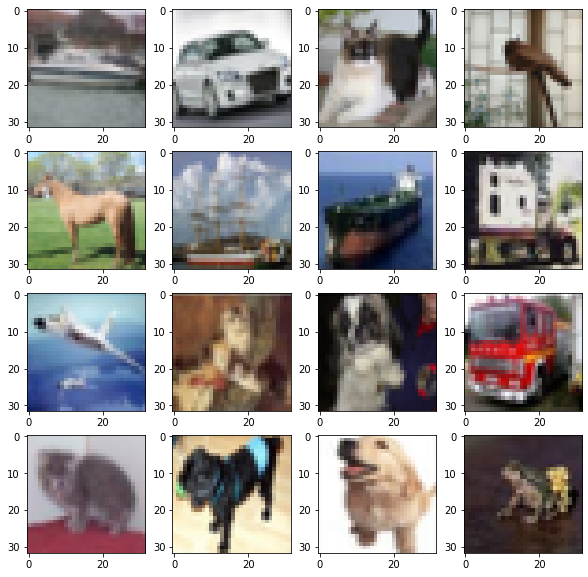

In [3]:
w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = random.choice(trainX)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [4]:
def process_data(train,test):

  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  return train_norm, test_norm

def get_categorical(y_train,y_test):
  trainY = to_categorical(y_train)
  testY = to_categorical(y_test)
  return trainY, testY



In [5]:
print(trainX[0].shape)

(32, 32, 3)


In [6]:
class GetData():
  
  def __init__(self):

    self.class_dict = { 0: 'airplane',1: 'automobile',2: 'bird',3: 'cat',4: 'deer',5: 'dog',6: 'frog',7: 'horse',8: 'ship',9: 'truck'}
    self.animal_class = [2,3,4,5,6,7]
    self.transport_class = [0,1,8,9]
    self.X_train,self.X_test = process_data(trainX,testX)
    self.y_train, self.y_test = trainy, testy

  # task a: individual category classes
  def task_a(self):
      y_train_a,y_test_a = get_categorical(self.y_train,self.y_test)
      return y_train_a, y_test_a
    
  # task b: animal (0) vs transport (1)
  def task_b(self):
      y_train_b = np.array([np.array([0]) if i[0] in self.animal_class else np.array([1]) for i in  self.y_train])
      y_test_b = np.array([np.array([0]) if i[0] in self.animal_class else np.array([1]) for i in  self.y_test])
      y_train_b, y_test_b = get_categorical(y_train_b,y_test_b)
      return y_train_b, y_test_b

  # task c: reconstruction
  def task_c(self):
      return self.X_train, self.X_test
  
  # task d: random labels
  def task_d(self):
    y_train_d = np.array([ np.array(random.choice([0,1])) for i in  self.y_train])
    y_test_d = np.array([np.array(random.choice([0,1])) for i in  self.y_test])
    y_train_d, y_test_d = get_categorical(y_train_d,y_test_d)
    return y_train_d, y_test_d



In [7]:
get_data = GetData()
X_train, X_test = get_data.X_train, get_data.X_test

(y_train_a,y_test_a) = get_data.task_a()
(y_train_b, y_test_b) = get_data.task_b()
(y_train_c ,y_test_c) = get_data.task_c()
(y_train_d ,y_test_d) = get_data.task_d()

In [8]:
#Define neural network parameters

class ModelParams():

  def __init__(self):
    self.n_classes_a = 10
    self.n_classes_b = 2
    self.epochs= 10000
    self.lr = 1e-3
    self.BS = 128
    self.iter_epoch = len(trainX)// self.BS
    self.save_period = 10
    self.latent_size = 32
    self.depth = 3
    self.chanDim =-1
    #self.checkpoint_path = "./content/model_checkpoints"
    #if not os.path.exists(self.checkpoint_path):
    #    os.mkdir(self.checkpoint_path)

    #self.tb_log_path = "./content/tensorboard_logs"
    #if not os.path.exists(self.tb_log_path):
    #    os.mkdir(self.tb_log_path)
        
    #self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=self.tb_log_path)


    # #self.cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #     filepath=self.checkpoint_path, 
    #     verbose=1, 
    #     save_weights_only=True,
    #     save_freq= int(self.save_period * self.iter_epoch))

    self.history = History()

In [9]:
model_params = ModelParams()

In [10]:
#Build the shared model network



def BuildModel():
  input_shape = (32, 32, 3)
  input = Input(shape=input_shape)

  x = Conv2D(8, kernel_size=3, activation='relu',strides =2, padding='same')(input)
  x = Dropout(0.2)(x)
  #x = MaxPooling2D(pool_size=(2, 2))(x)
  x = BatchNormalization(axis=model_params.chanDim)(x)

  x = Conv2D(16, kernel_size=3, activation='relu',strides =2, padding='same')(x)
  x = Dropout(0.2)(x)
  #x = MaxPooling2D(pool_size=(2, 2))(x)
  x = BatchNormalization(axis=model_params.chanDim)(x)

  x = Conv2D(32, kernel_size=3, activation='relu',strides =2, padding='same')(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization(axis=model_params.chanDim)(x)
  y = GlobalMaxPooling2D()(x)

  volumeSize = K.int_shape(x)
  f = Flatten()(x)
  latent = Dense(model_params.latent_size)(f)


  #task a output
  dense_a = Dense(256, activation="relu")(y)
  output_a = Dense(y_train_a.shape[1], activation='softmax', name = 'cifar10_original')(dense_a)

  #task b output
  dense_b  = Dense(256, activation="relu")(y)
  output_b = Dense(y_train_b.shape[1], activation='softmax', name = 'animal_vs_non-animal')(dense_b)

  #task c output  
  dense_c = Dense(np.prod(volumeSize[1:]))(latent) #(latentInputs)
  inp_c = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(dense_c)
  
  #(decoder network for task c)
  x_c = Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same',strides =2)(inp_c)
  x_c = Dropout(0.2)(x_c)
  x_c = BatchNormalization(axis=model_params.chanDim)(x_c)
  #x_c = MaxPooling2D(pool_size=(2, 2))(x_c)
  x_c = Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same',strides =2)(x_c)
  x_c = Dropout(0.2)(x_c)
  x_c = BatchNormalization(axis=model_params.chanDim)(x_c)
  #x_c = MaxPooling2D(pool_size=(2, 2))(x_c)
  x_c = Conv2DTranspose(8, kernel_size=3, activation='relu', padding='same',strides =2)(x_c)
  x_c = Dropout(0.2)(x_c)
  x_c = BatchNormalization(axis=model_params.chanDim)(x_c)
  #x_c = MaxPooling2D(pool_size=(2, 2))(x_c)
  
  output_c = Conv2DTranspose(model_params.depth, (3, 3), activation='sigmoid',padding="same",name = 'reconstruction')(x_c)
  
  #task d output
  dense_d  = Dense(256, activation="relu")(y)
  output_d = Dense(y_train_d.shape[1], activation='softmax', name = 'random')(dense_d)

  model = Model(inputs=input, outputs=[output_a, output_b, output_c])
  model_cifar = Model(inputs=input, outputs=output_a)
  model_an_vs_non = Model(inputs=input, outputs=output_b)
  model_recon = Model(inputs=input, outputs=output_c)
  # #Geometric mean of losses
  # label_layer_a = Input((1,)) 
  # label_layer_b = Input((1,))
  # label_layer_c = Input(input_shape)
  # label_layer_d = Input((1,))
  # custom_loss = gm_metric.update_state([tf.keras.losses.CategoricalCrossentropy(output_a,label_layer_a),tf.keras.losses.BinaryCrossentropy(output_b,label_layer_b), 
  #                                       tf.keras.losses.KLDivergence(output_c,label_layer_c),tf.keras.losses.BinaryCrossentropy(output_d,label_layer_d) ]).result()
  
  # model.add_loss(custom_loss)


  # print(model.summary())
  # # model.compile(loss=['categorical_crossentropy', 'binary_crossentropy', 'mse','binary_crossentropy'],
  # #               optimizer=Adam(clipnorm = 1.), metrics = {'cifar10_original': 'accuracy','animal_vs_transport':'accuracy',
  # #                                                       'reconstruction':'mean_squared_error','random':'accuracy'}, loss_weights = [0.5, 0.1, 1,0.1])
  # model.compile(
  #                optimizer=Adam(clipnorm = 1.))
  return model,model_cifar,model_an_vs_non,model_recon
  


In [11]:
model_mtl1, model_cifar,model_an_vs_non, model_recon  = BuildModel()

In [12]:
model_recon.compile(loss='mse',
                optimizer=Adam(clipnorm = 1.,lr=model_params.lr), metrics = {'reconstruction': 'mean_squared_error'})
model_recon.fit(X_train,y_train_c,
                    steps_per_epoch = model_params.iter_epoch,
                    epochs = model_params.epochs,
                    validation_data=(X_test,y_test_c),batch_size=model_params.BS,callbacks=[model_params.history],shuffle=True)

Epoch 1/10000
390/390 [==============================] - 70s 174ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 2/10000
390/390 [==============================] - 67s 171ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 3/10000
390/390 [==============================] - 67s 171ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 4/10000
390/390 [==============================] - 65s 168ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 5/10000
390/390 [==============================] - 65s 167ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 6/10000
390/390 [==============================] - 66s 168ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0205 - val_mean_squared_error:

KeyboardInterrupt: ignored

In [ ]:
model_an_vs_non.compile(loss='binary_crossentropy',
                optimizer=Adam(clipnorm = 1.), metrics = {'animal_vs_non-animal': 'accuracy'})
model_an_vs_non.fit(X_train,y_train_b,
                    steps_per_epoch = model_params.iter_epoch,
                    epochs = model_params.epochs,
                    validation_data=(X_test,y_test_b),batch_size=model_params.BS,callbacks=[model_params.history],shuffle=True)

Epoch 1/10000
390/390 [==============================] - 70s 177ms/step - loss: 0.4607 - accuracy: 0.7842 - val_loss: 0.3178 - val_accuracy: 0.8834
Epoch 2/10000
390/390 [==============================] - 66s 170ms/step - loss: 0.2775 - accuracy: 0.8868 - val_loss: 0.2861 - val_accuracy: 0.8999
Epoch 3/10000
390/390 [==============================] - 67s 171ms/step - loss: 0.2375 - accuracy: 0.9047 - val_loss: 0.2631 - val_accuracy: 0.9041
Epoch 4/10000
390/390 [==============================] - 66s 168ms/step - loss: 0.2155 - accuracy: 0.9167 - val_loss: 0.2421 - val_accuracy: 0.9086
Epoch 5/10000
390/390 [==============================] - 65s 168ms/step - loss: 0.2074 - accuracy: 0.9187 - val_loss: 0.2373 - val_accuracy: 0.9105
Epoch 6/10000
390/390 [==============================] - 66s 168ms/step - loss: 0.1884 - accuracy: 0.9276 - val_loss: 0.2119 - val_accuracy: 0.9262
Epoch 7/10000
390/390 [==============================] - 65s 168ms/step - loss: 0.1805 - accuracy: 0.9310 - val_

KeyboardInterrupt: ignored

In [ ]:
#evaluate model


eval_list = model_an_vs_non.evaluate(X_test,y_test_b)
print('Test Loss: ',eval_list[0])
print('Test Accuracy: ',eval_list[1])


313/313 [==============================] - 4s 14ms/step - loss: 0.1738 - accuracy: 0.9441
Test Loss:  0.1738041192293167
Test Accuracy:  0.944100022315979


In [ ]:
model_params.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

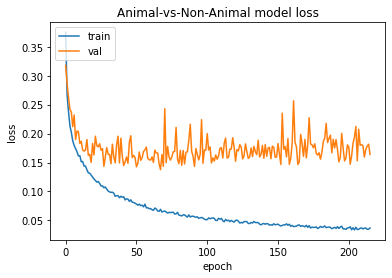

In [ ]:
#Animal vs Non-Anomal loss

plt.plot(model_params.history.history['loss'])
plt.plot(model_params.history.history['val_loss'])
plt.title('Animal-vs-Non-Animal model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

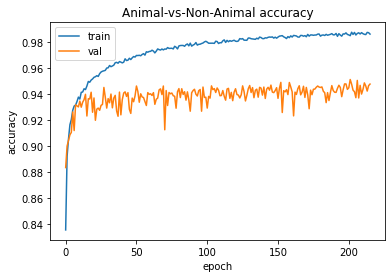

In [ ]:
#Animal vs Non-Anomal Accuracy
plt.plot(model_params.history.history['accuracy'])
plt.plot(model_params.history.history['val_accuracy'])
plt.title('Animal-vs-Non-Animal accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Animal vs non animal
# Epoch 217/10000 : loss: 0.0339 - accuracy: 0.9872 - val_loss: 0.1640 - val_accuracy: 0.9477

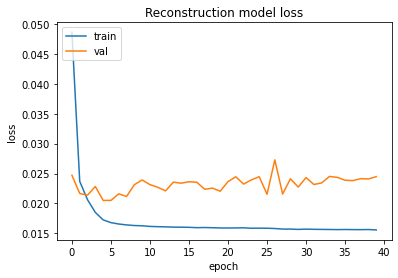

In [13]:
#recon Model Loss Visualization
#conv = [8,16,32]
# batch normalization

plt.plot(model_params.history.history['loss'])
plt.plot(model_params.history.history['val_loss'])
plt.title('Reconstruction model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

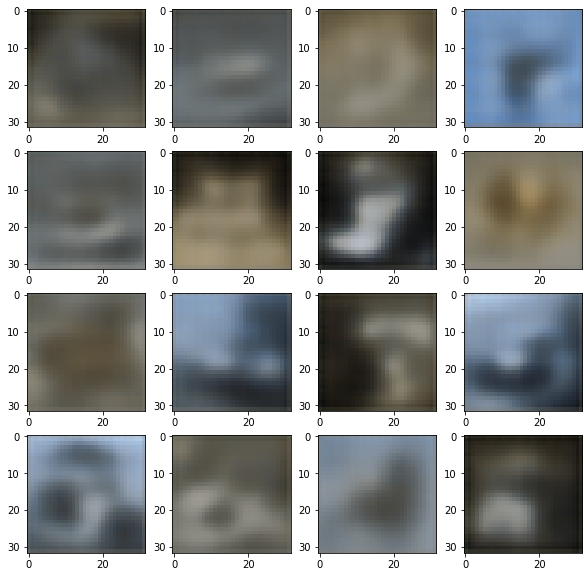

In [14]:
predictions = model_recon.predict(X_test)
w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = random.choice(predictions)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()